In [1]:
#!pip install wordcloud
#!pip install textblob

In [3]:
from PIL import Image
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt 
import matplotlib
import regex as re

%matplotlib inline

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

## Let's do some exploratory data analysis and visualization! First let's load our raw data: tweets by Donald Trump.

In [4]:
data = pd.read_csv("../data/tweets_01-08-2021.csv")
print(data.shape)

(56571, 9)


We have ~56000 rows and 9 features. Let's take a look at some rows in our dataframe

In [5]:
data.head(10)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56,f
6,1223640662689689602,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,f
7,1319501865625784320,https://t.co/4qwCKQOiOw,f,f,Twitter for iPhone,130822,19127,2020-10-23 04:52:14,f
8,1319500520126664705,https://t.co/VlEu8yyovv,f,f,Twitter for iPhone,153446,20275,2020-10-23 04:46:53,f
9,1319500501269041154,https://t.co/z5CRqHO8vg,f,f,Twitter for iPhone,102150,14815,2020-10-23 04:46:49,f


Interesting, we have quite a lot of information on his tweets. We know the date, device, how many favorites and retweets it received, whether it was a retweet itself, and whether it was deleted, which is our outcome feature in this project. For the text itself, we can see that some tweets have the plain text itself, while others have "RT" text and links cluttering the text. We'll have to handle that as we analyze the text closely.

## Before we visualize our features, can we get an idea of what these tweets look like? Can we look at the most popular tweets and see what they say?

In [6]:
df_favorite = data.sort_values(by = ['favorites'], ascending = False)
N = 5
top_N = df_favorite.iloc[0:N, 1]
for i in range(0,N):
    print(str(i + 1) + ". " + top_N.iloc[i])
    print()

1. Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

2. Going welI, I think! Thank you to all. LOVE!!!

3. I WON THIS ELECTION, BY A LOT!

4. WE WILL WIN!

5. 71,000,000 Legal Votes. The most EVER for a sitting President!



We can see that we have plain text, with some numbers as well as "@" signs. Also, it appears that his most favorited tweets are related to his Covid positivity and his false 2020 election claims.

Now, let's dive into some visualization...

## Let's graph the frequency of tweets over time, to get an idea of our spread over time.

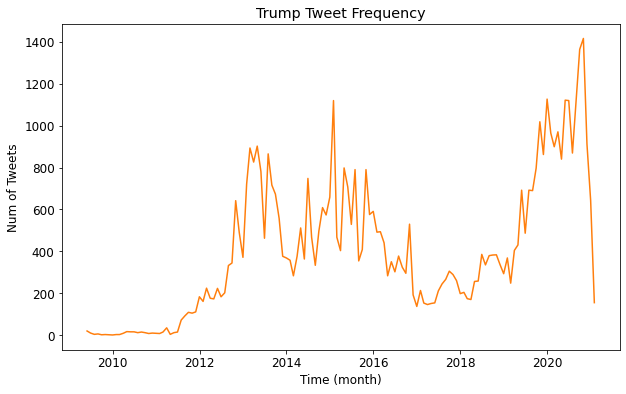

In [7]:
# Group tweets by month
data['date']=pd.to_datetime(data['date'])
date_group = data
date_group.index = pd.to_datetime(data['date'])
date_group = data.groupby(pd.Grouper(freq='M')).count()
date_group = date_group["id"]

# Plot frequency graph
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(date_group.index, date_group, color='tab:orange')

ax.set_xlabel('Time (month)')
ax.set_ylabel('Num of Tweets')
ax.set_title('Trump Tweet Frequency')
plt.savefig("../figs/tweet_frequency.jpg")

There are some expected and unexpected results from this graph. Expectedly, we see that Trump's tweet frequency follows US election cycles, picking up 2015-2016 and 2019-2020. What is slightly unexpected is how sharply the decline in tweets was after each election, and how many more tweets there were in the 202 election cycle as opposed to the 2016 election cycle.

## Now, let's see if we can chart the breakdown of which devices the tweets come from, to see if they're all coming from Trump's personal phone, or from several devices.

['TweetDeck' 'Twitter for iPhone' 'Twitter Media Studio'
 'Twitter for Android' 'Twitter Web Client' 'Twitter Web App' 'Instagram'
 'Twitter for iPad' 'Twitter Ads' 'Facebook' 'Periscope' 'TwitLonger Beta'
 'Twitter QandA' 'Twitlonger' 'Vine - Make a Scene'
 'Twitter for BlackBerry' 'Twitter for Websites' 'Twitter Mirror for iPad'
 'Neatly For BlackBerry 10' 'Media Studio']


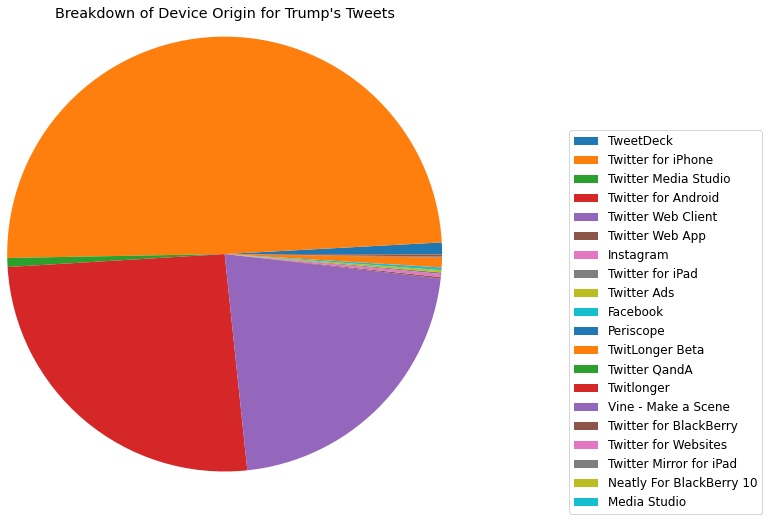

In [8]:
# Pie chart for devices
n = data.shape[0]
d = data.shape[1]

device_list = data['device'].unique()
device_ratios = []
for device in device_list:
    curr_ratio = data[data['device'] == device].shape[0]/n
    device_ratios.append(curr_ratio)

#myexplode = [0.2, 0, 0, 0]
print(device_list)
fig1, ax1 = plt.subplots(figsize=(6, 5))

ax1.pie(device_ratios, radius=2)
ax1.legend(
    loc='center right',
    labels = device_list,
    prop={'size': 12},
    bbox_to_anchor=(-0.5, 0, 3, 0.5),
)
ax1.set_title("Breakdown of Device Origin for Trump's Tweets", pad = 100)
plt.show() 
fig1.savefig("../figs/device_chart.jpg", bbox_inches = 'tight')

We can see that while the majority of tweets are from Trumps Offices' iPhone, Android, and desktop, there is a large variety of devices from which his tweets originate. This tells us that while the majority of the tweets likely came from his personal mobile devices over the years, there's a minority of tweets that likely came from an agent/communications director on his team.

## Now let's see some of the ratio balances in our data. How many tweets were retweets, or deleted? Or how many were from certain devices?

[0.007760159799190398, 0.16683459723179722]
[0.011543016740025808, 0.8138622262289866]


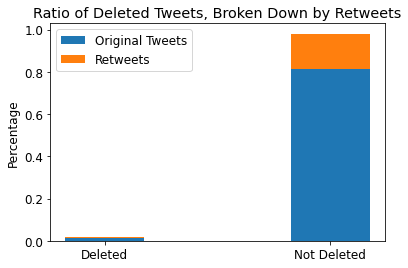

In [9]:
labels = ['Deleted', 'Not Deleted']
df_deleted = data[data['isDeleted'] == 't']
df_notdeleted = data[data['isDeleted'] == 'f']
dfs = [df_deleted, df_notdeleted]
normal_tweet_ratios = []
retweet_ratios = []

for df in dfs:
    normal_tweet_ratio = df[df['isRetweet'] == 'f'].shape[0]/n
    retweet_ratio = df[df['isRetweet'] == 't'].shape[0]/n
    normal_tweet_ratios.append(normal_tweet_ratio)
    retweet_ratios.append(retweet_ratio)

#men_means = [20, 35, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]
width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
print(str(retweet_ratios) + "\n" + str(normal_tweet_ratios))

ax.bar(labels, normal_tweet_ratios, width, label='Original Tweets')
ax.bar(labels, retweet_ratios, width, bottom=normal_tweet_ratios, label='Retweets')

ax.set_ylabel('Percentage')
ax.set_title('Ratio of Deleted Tweets, Broken Down by Retweets')
ax.legend()

plt.show()
fig.savefig("../figs/deletion_ratio.jpg")

We can see that the vast majority of Trump's tweets were not deleted, so we have an unbalanced dataset on our hands. In addition, among the deleted tweets, the balance between original tweets and retweets is close, while the balance of original tweets to retweets is majority original among the non-deleted tweets.

## Now, let's take the topics from our LDA model and see if we can piece-together some patterns/themes 

In [11]:
# tweets with topic labels
topic_modeled = pd.read_csv('../output/tweets_with_topic_label.csv')

# sentiment data from Olha's branch
sentiment_analysis_clean = pd.read_csv('../output/sentiment_analysis_clean.csv')
sentiment_labels = pd.read_csv('../output/sentiment_labels.csv')

# most frequent words in topics
topic_tops = pd.read_csv('../output/topic top words v2.csv')

In [12]:
topic_modeled['idx'] = topic_modeled.index
sentiment_labels.rename(columns={'Unnamed: 0':'idx'}, inplace=True)

In [13]:
topic_modeled = pd.merge(sentiment_labels,topic_modeled.drop(['id','text'], axis = 1),on='idx')

In [14]:
# Check if they are retweets: there are retweets in the middle of the text
tweets = topic_modeled['text'].to_list()
values = []

for tweet in tweets:
    if tweet.find('RT @') == -1:
        value = False
    else:
        value = True
    values.append(value)

topic_modeled['RT'] = values

In [15]:
print(len(sentiment_analysis_clean))
print(len(topic_modeled))
print(len(topic_modeled[topic_modeled.RT==False])) #if contains "RT @"
print(len(sentiment_analysis_clean[sentiment_analysis_clean.isRetweet=='f']))
print(len(sentiment_analysis_clean[sentiment_analysis_clean.retweeted==False])) #if startswith "RT"

54674
54422
44734
45133
45317


In [16]:
# Extract time from date
topic_modeled['date'] = topic_modeled.date.astype('datetime64[ns]')
#topic_modeled['year'] = topic_modeled.date.dt.year
#topic_modeled['day'] = topic_modeled.date.dt.date
#topic_modeled['month'] = topic_modeled.date.dt.month
topic_modeled['time'] = topic_modeled.date.dt.time
topic_modeled['hour'] = pd.to_numeric(topic_modeled.date.dt.hour)

In [17]:
[print(str(i),'\n',Counter(topic_modeled[i]),'\n','-'*30) for i in ['device','isDeleted','RT','Topic','hour','Final']]

device 
 Counter({'Twitter for iPhone': 25988, 'Twitter for Android': 14471, 'Twitter Web Client': 12122, 'TweetDeck': 481, 'TwitLonger Beta': 402, 'Twitter Media Studio': 347, 'Instagram': 133, 'Facebook': 105, 'Twitter Ads': 96, 'Twitter for BlackBerry': 96, 'Twitter Web App': 64, 'Twitter for iPad': 59, 'Twitlonger': 23, 'Twitter QandA': 10, 'Vine - Make a Scene': 10, 'Periscope': 6, 'Neatly For BlackBerry 10': 5, 'Media Studio': 2, 'Twitter for Websites': 1, 'Twitter Mirror for iPad': 1}) 
 ------------------------------
isDeleted 
 Counter({'f': 53423, 't': 999}) 
 ------------------------------
RT 
 Counter({False: 44734, True: 9688}) 
 ------------------------------
Topic 
 Counter({0: 7519, 3: 7141, 9: 6895, 4: 5834, 6: 5337, 2: 4767, 1: 4745, 5: 4659, 7: 3809, 8: 3716}) 
 ------------------------------
hour 
 Counter({12: 3656, 20: 3607, 19: 3408, 13: 3282, 11: 3027, 14: 2996, 18: 2930, 2: 2893, 15: 2805, 21: 2804, 1: 2649, 16: 2527, 3: 2518, 22: 2331, 0: 2270, 17: 2237, 23: 2

[None, None, None, None, None, None]

In [18]:
topic_modeled

,idx,id,text,sentiment_text,subjectivity_score,VADER,TextBlob,W2V-kNN,Final,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,Topic,RT,time,hour
0,0,98454970654916608,Republicans and Democrats have both created ou...,republicans democrats created economic problems,0.200000,-1,1,-1,-1,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,0,False,18:07:48,18
1,1,1234653427789070336,I was thrilled to be back in the Great city of...,thrilled_back great city charlotte north_carol...,0.483333,1,1,-1,1,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,6,False,01:34:50,1
2,2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,read letter surveillance court obtained cbs ne...,0.100000,0,1,1,1,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,6,True,03:22:47,3
3,3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail_ballot scam major threat demo...,0.454762,-1,1,-1,-1,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,5,False,20:10:58,20
4,4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,friendly telling events comey apparent leaking...,0.425000,1,1,-1,1,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,9,True,13:13:59,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54417,54669,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,’ know thinks continue lie wants ban_fracking ...,0.100000,-1,1,1,1,t,f,Twitter for iPhone,0,44406,2019-05-18 21:23:59,f,6,True,21:23:59,21
54418,54670,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,president excels communicating directly americ...,0.000000,1,0,1,1,t,f,Twitter for iPhone,0,38687,2019-05-18 21:23:43,f,3,True,21:23:43,21
54419,54671,1319444420861829121,RT @TeamTrump: LIVE: Presidential Debate #Deba...,live presidential_debate text vote,0.500000,0,1,-1,0,t,f,Twitter for iPhone,0,12190,2019-05-18 21:16:18,f,6,True,21:16:18,21
54420,54672,1319384118849949702,Just signed an order to support the workers of...,signed order support workers delphi corporatio...,0.260317,0,-1,-1,-1,t,f,Twitter for iPhone,0,6975,2019-05-18 21:15:59,f,2,False,21:15:59,21


In [19]:
# save 
topic_modeled.to_csv(r'../output/data_for_analysis.csv', index=False)

## 30 most frequent words in topics

In [20]:
# frequency ascending
for i in range(len(topic_tops)):
    print(topic_tops.iloc[i,1])
    print('-'*50)

[['wait', 'teamtrump', 'service', 'building', 'press', 'million', 'war', 'energy', 'truly', 'dont', 'lot', 'candidate', 'remember', 'open', 'presidential', 'end', 'problem', 'live', 'place', 'soon', 'doesnt', 'white', 'nation', 'whitehouse', 'sta', 'people', 'better', 'watch', 'look', 'house']]
--------------------------------------------------
[['absolutely', 'highest', 'given', 'robe', 'mark', 'miss', 'save', 'celebrity', 'win', 'russian', 'apprenticenbc', 'god', 'wow', 'ivankatrump', 'happen', 'stand', 'celebapprentice', 'apprentice', 'justice', 'case', 'senator', 'cou', 'witch', 'hunt', 'rating', 'book', 'congratulation', 'tonight', 'best', 'great']]
--------------------------------------------------
[['failing', 'success', 'texas', 'going', 'price', 'south', 'truth', 'cruz', 'tariff', 'drug', 'korea', 'federal', 'company', 'lie', 'schiff', 'lost', 'happy', 'york', 'hit', 'fantastic', 'iran', 'time', 'course', 'wall', 'border', 'fbi', 'security', 'story', 'record', 'national']]
---

We can see some expected themes from the topic model. There is a topic regarding election fraud, with words such as "fraud, phony, vote, dems, fake and news". But, many topics share common themes. For example, Trumps MAGA slogen appears in several topics, as does "america", "democrat" and "vote/voter". This likely speaks to the overlap of prose in Trump's declarations; the topics are not cleanly segmeneted.

In [21]:
topic_labels = ['Whitehouse','Apprentice Show','National security','Election','MAGA',
                'Fake news','Hillary & Obama','President Trump','Interviews','China']

In [22]:
# 'realdonaldtrump' is occurs very frequently in topics
# so check if texts contain 'realdonaldtrump'
tweets = topic_modeled['text'].to_list()
values = []

for tweet in tweets:
    if tweet.find('realdonaldtrump') == -1:
        value = False
    else:
        value = True
    values.append(value)

topic_modeled['realdonaldtrump']= values

In [23]:
print(len(topic_modeled[(topic_modeled.realdonaldtrump==True)]))
print(len(topic_modeled[(topic_modeled.realdonaldtrump==True) & (topic_modeled.RT==False)].text))

123
81


## Heatmap: Tweet topic vs. device

In [24]:
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    inputs
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.

    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            if a[i,j] == np.max(a, axis=1)[i]:
                text = ax.text(j, i, a[i, j],fontsize=15, 
                           ha="center", va="center", color="orange", weight="bold")
            else:
                text = ax.text(j, i, a[i, j],fontsize=13,
                           ha="center", va="center", color="black",alpha=0.8)

    return im, cbar

In [25]:
# (target) topic variable
topic_val = list(sorted(Counter(topic_modeled.Topic).keys()))

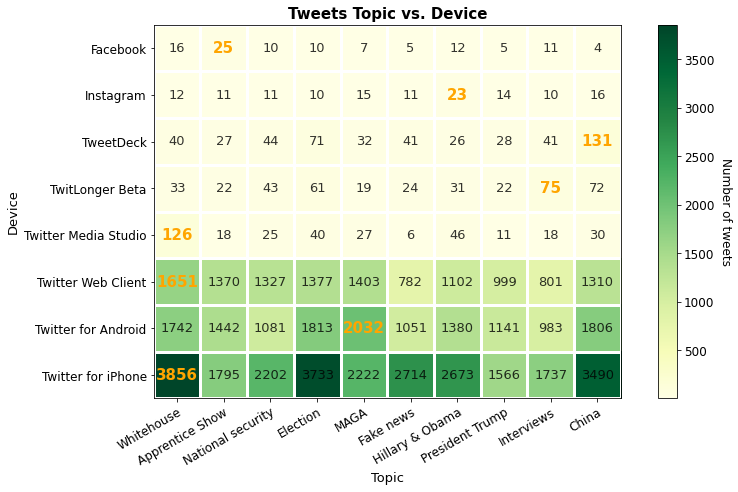

In [26]:
# device variable
device_val= list(sorted(Counter(topic_modeled.device).keys()))

counts=[]
for i in device_val:
    counts.append([i, sum(Counter(topic_modeled[topic_modeled.device==i]["Topic"]).values())])
df = pd.DataFrame(counts, columns=['device','counts'])#.sort_values(by='counts',ascending=False)[:10]
# Filters devices with 100+ tweets 
device_val=list(df[df.counts > 100].device)

# heatmap matrix

a = np.empty((0,len(topic_labels)),int)
for i in device_val:
    counter = Counter(topic_modeled[topic_modeled.device==i]["Topic"])
    row = np.array([dict(counter).get(key, 0) for key in topic_val]).reshape(-1,10)
    #row = np.array(list(dict(sorted(counter.items())).values())).reshape(-1,10)
    a= np.append(a, row, axis=0)

fig, ax = plt.subplots(figsize=(12,7))

im, cbar = heatmap(a, device_val, topic_labels, ax=ax,
                   cmap="YlGn", cbarlabel="Number of tweets")

ax.set_title("Tweets Topic vs. Device", fontsize=15, fontweight='bold')
ax.set_xlabel("Topic", fontsize=13)
ax.set_ylabel("Device", fontsize=13)
fig.tight_layout()
plt.show()

There's quite a lot going on in this heatmap, mainly because as we look across devices, we're not only looking at difference in topics by device, but also through time, since different devices were used during different time periods. So, for example, we can see that MAGA was a big topic on Trump's android device in comparison to others, so he may have used an Android during his campaign. Similarly, whitehouse is a big topic from twitter media studio, so we can guess that perhaps that was someone on the whitehouse staff tweeting for him, or for him on the campaign trail. 

## Heatmap: Topics of Deleted/Undeleted Tweets

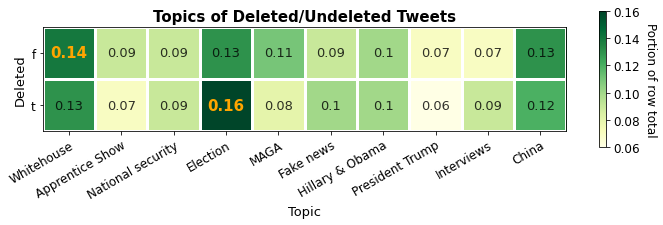

In [27]:
isdelete_val= list(sorted(Counter(topic_modeled.isDeleted).keys()))
# heatmap matrix

a = np.empty((0,len(topic_val)),int)
for i in isdelete_val:
    counter = Counter(topic_modeled[topic_modeled.isDeleted==i]["Topic"])
    row = np.array([dict(counter).get(key, 0) for key in topic_val]).reshape(-1,10)
    row = np.round(row/np.sum(row), decimals=2)
    #row = np.array(list(dict(sorted(counter.items())).values())).reshape(-1,10)
    a= np.append(a, row, axis=0)

fig, ax = plt.subplots(figsize=(10,3))

im, cbar = heatmap(a, isdelete_val, topic_labels, ax=ax,
                   cmap="YlGn", cbarlabel="Portion of row total")

ax.set_title("Topics of Deleted/Undeleted Tweets", fontsize=15, fontweight='bold')
ax.set_xlabel("Topic", fontsize=13)
ax.set_ylabel("Deleted", fontsize=13)
fig.tight_layout()
plt.show()

We immediatlely pick out what is expected in this graph: tweets relating to elections, and thereby Trump's claims of election fraud, were much more likely to be deleted due to Twitter's updated misinformation policies.

## Heatmap: Tweets Topic vs. Sentiment

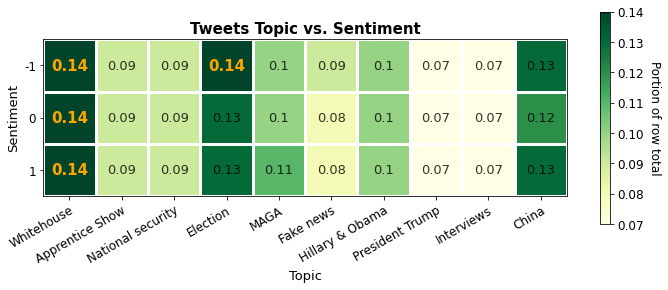

In [28]:
final_val= list(sorted(Counter(topic_modeled.Final).keys()))
# heatmap matrix

a = np.empty((0,len(topic_val)),int)
for i in final_val:
    counter = Counter(topic_modeled[topic_modeled.Final==i]["Topic"])
    row = np.array([dict(counter).get(key, 0) for key in topic_val]).reshape(-1,10)
    row = np.round(row/np.sum(row), decimals=2)
    #row = np.array(list(dict(sorted(counter.items())).values())).reshape(-1,10)
    a= np.append(a, row, axis=0)

fig, ax = plt.subplots(figsize=(10,4))

im, cbar = heatmap(a, final_val, topic_labels, ax=ax,
                   cmap="YlGn", cbarlabel="Portion of row total")

ax.set_title("Tweets Topic vs. Sentiment", fontsize=15, fontweight='bold')
ax.set_xlabel("Topic", fontsize=13)
ax.set_ylabel("Sentiment", fontsize=13)
fig.tight_layout()
plt.show()

This is quite interesting. Most of these topics seem to have nearly equal sentiment value, meaning that these topics appear in positive/negative/neutral contexts all the same. Election topics are slightly more negative, but overall it seems that the sentiment is fairly balanced, whereas we may have expected political sentiment to bias towards negative.

## Heatmap: Tweets Sentiment vs. Device

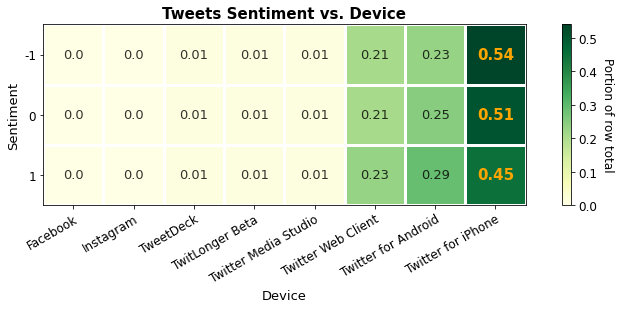

In [29]:
final_val= list(sorted(Counter(topic_modeled.Final).keys()))
# heatmap matrix

a = np.empty((0,len(device_val)),int)
for i in final_val:
    counter = Counter(topic_modeled[topic_modeled.Final==i]["device"])
    row = np.array([dict(counter).get(key, 0) for key in device_val]).reshape(-1,8)
    row = np.round(row/np.sum(row), decimals=2)
    #row = np.array(list(dict(sorted(counter.items())).values())).reshape(-1,10)
    a= np.append(a, row, axis=0)

fig, ax = plt.subplots(figsize=(11,4))

im, cbar = heatmap(a, final_val, device_val, ax=ax,
                   cmap="YlGn", cbarlabel="Portion of row total")


ax.set_title("Tweets Sentiment vs. Device", fontsize=15, fontweight='bold')
ax.set_xlabel("Device", fontsize=13)
ax.set_ylabel("Sentiment", fontsize=13)
fig.tight_layout()
plt.show()

Based on this heatmap we may assume that Trump used his iPhone for the majority of tweets during his campaign and presidency. Not only does that device have the majority of tweets overall, but also the sentiment biases negatively, and during his term his tweeting was infamous for its inflammatory nature.

## WordCloud for each topic

In [30]:
delete = topic_modeled[topic_modeled.isDeleted=='t'].sentiment_text
len(delete)

999

In [34]:
import cv2
path = "../output/"

# create image mask
img_grey = cv2.imread('../figs/trump.png', cv2.IMREAD_GRAYSCALE)
thresh = 240
# threshold the image
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]
#save image
cv2.imwrite(os.path.join(path, "trump_mask.png"),img_binary) 

True

In [36]:
trump_mask = np.array(Image.open(os.path.join(path, "trump_mask.png")))
trump = np.array(Image.open('../figs/trump.png'))
image_colors = ImageColorGenerator(trump)

In [37]:
stopwords = set(STOPWORDS)
overused = ['thank','thanks','new','big','nice','like','time','year','years','know','think','thought',
            'want','good','little','never','wants','want','thing','follow','followed','go','going','way','love',
            'see','saw','high','low','say','says','day','today','different','realdonaldtrump','amp','true','really']
for i in overused:
    stopwords.add(i)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_wordcloud(topic=0, topic_label=''):
    freq_dict = dict(get_top_n_words(topic_modeled[topic_modeled.Topic==topic].sentiment_text))
    for i in stopwords:
        if i in freq_dict:
            freq_dict.pop(i)
    wordcloud = WordCloud(font_path='../data/Candara.ttf',
                        background_color='white',
                        max_words=100,
                        max_font_size=100, 
                        mask=trump_mask,
                        random_state=42).generate_from_frequencies(freq_dict)
    fig = plt.figure(figsize=(8,8))
    #plt.imshow(wordcloud)
    plt.imshow(wordcloud.recolor(color_func=image_colors))#, interpolation="bilinear")
    plt.axis('off')
    plt.title('Topic {}: {}'.format(topic,topic_label), fontsize=15, fontweight='bold')
    plt.show()

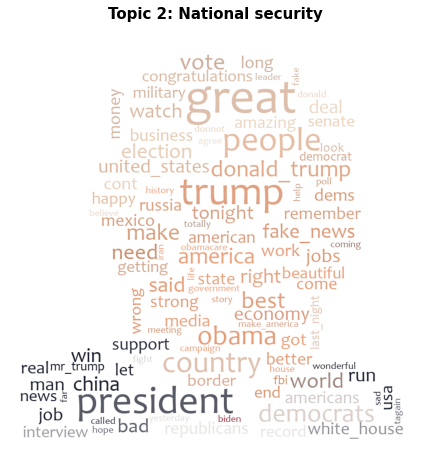

In [39]:
plot_wordcloud(topic=2, topic_label=topic_labels[2])

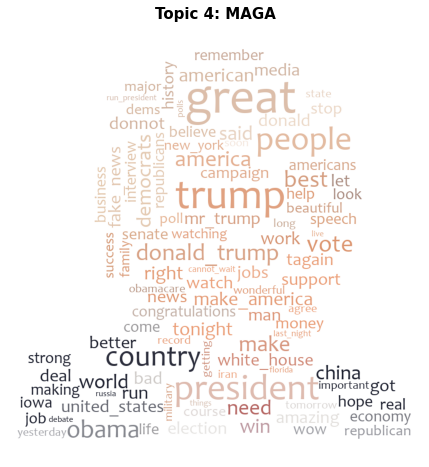

In [40]:
plot_wordcloud(topic=4, topic_label=topic_labels[4])

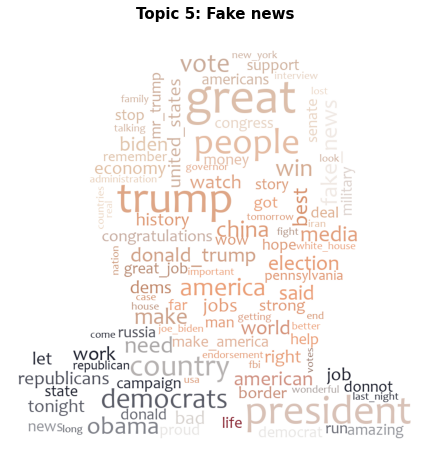

In [41]:
plot_wordcloud(topic=5, topic_label=topic_labels[5])

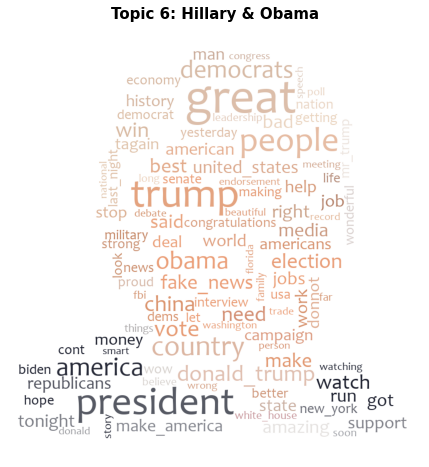

In [42]:
plot_wordcloud(topic=6, topic_label=topic_labels[6])

## Effects of topics

In [43]:
avg_retweets = topic_modeled.groupby('Topic')['retweets'].agg(np.mean)
avg_favorites = topic_modeled.groupby('Topic')['favorites'].agg(np.mean)
#ratio = avg_retweets/avg_favorites

#df = np.array([topic_labels, list(avg_retweets), list(avg_favorites), list(ratio)])
#topic_summary = pd.DataFrame(df.T, columns=['topic','avg_retweets','avg_favorites','retweets_favorites_ratio'])

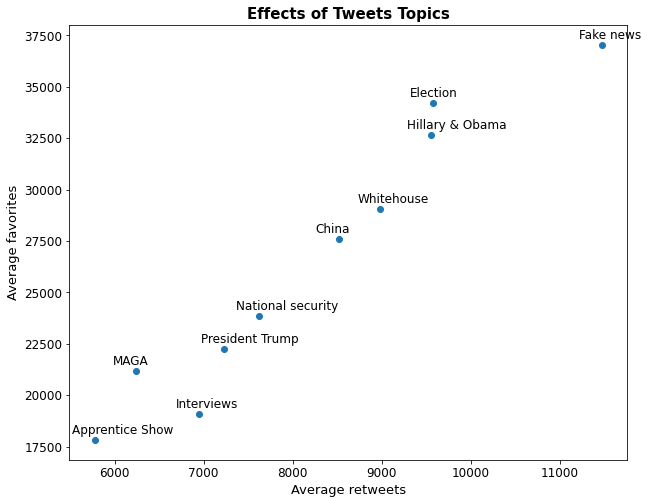

In [44]:
plt.figure(figsize=(10,8))
plt.scatter(avg_retweets, avg_favorites)
for i, txt in enumerate(topic_labels):
    plt.annotate(txt, (avg_retweets[i]-260, avg_favorites[i]+300))
plt.xlabel('Average retweets', fontsize=13)
plt.ylabel('Average favorites', fontsize=13)
plt.title('Effects of Tweets Topics', fontsize=15, fontweight='bold')
plt.show()

**Tweets of the fake news topic has the highest average retweets and favorites; the Apprentice show tweets were published in earlier years before Trump was elected, thus the relevant tweets had the lowest effects**

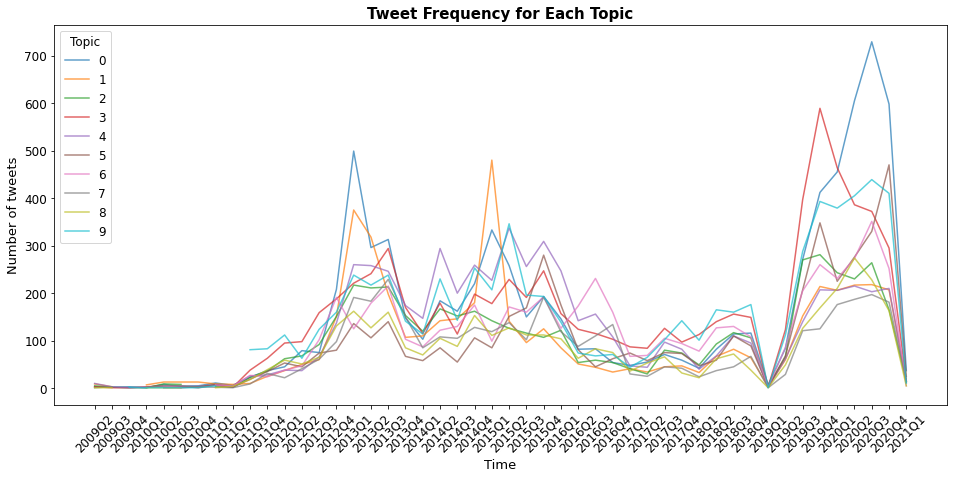

In [45]:
topic_modeled['yr-qt'] = topic_modeled.date.dt.year.astype(str) + 'Q' +topic_modeled.date.dt.quarter.astype(str)
topic_modeled['yr-m'] = topic_modeled.date.dt.year.astype(str) + '-' +topic_modeled.date.dt.month.astype(str)
# plot data
fig, ax = plt.subplots(figsize=(16,7))
# use unstack()
topic_modeled.groupby(['yr-qt','Topic'])['idx'].count().unstack().plot(ax=ax,alpha=0.7)#ls=('dashed'),
plt.xlabel('Time', fontsize=13)
plt.ylabel('Number of tweets', fontsize=13)
plt.title('Tweet Frequency for Each Topic', fontsize=15, fontweight='bold')
plt.xticks(np.arange(topic_modeled['yr-qt'].nunique()), np.sort(topic_modeled['yr-qt'].unique()), rotation=45)
plt.show()

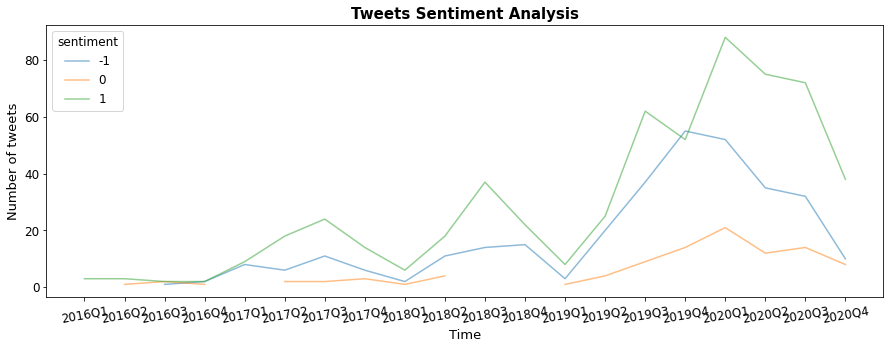

In [46]:
# plot data
fig, ax = plt.subplots(figsize=(15,5))
# use unstack()

data = topic_modeled[topic_modeled.isDeleted=='t']
data['sentiment'] = data.Final
(data.groupby(['yr-qt','sentiment'])['idx'].count().unstack().plot(ax=ax,alpha=0.5))
plt.xlabel('Time', fontsize=13)
plt.ylabel('Number of tweets', fontsize=13)
plt.title('Tweets Sentiment Analysis', fontsize=15, fontweight='bold')
plt.xticks(np.arange(data['yr-qt'].nunique()), np.sort(data['yr-qt'].unique()), rotation=10)
plt.show()

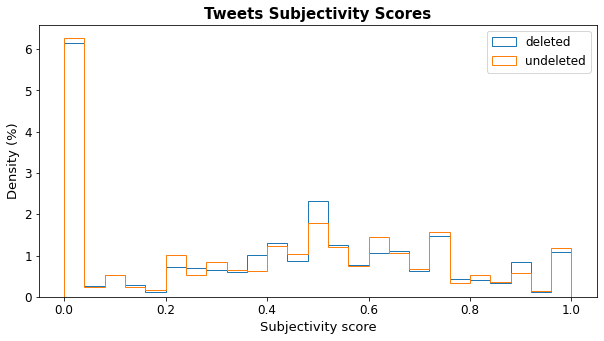

In [47]:
# No noticeable trend
deleted = topic_modeled[topic_modeled.isDeleted=='t']
undeleted = topic_modeled[topic_modeled.isDeleted=='f']
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(deleted['subjectivity_score'], 25, histtype='step', stacked=True, fill=False,density = True, label='deleted')
plt.hist(undeleted['subjectivity_score'], 25, histtype='step', stacked=True, fill=False,density = True, label='undeleted')
plt.xlabel('Subjectivity score', fontsize=13)
plt.ylabel('Density (%)', fontsize=13)
plt.title('Tweets Subjectivity Scores', fontsize=15, fontweight='bold')
plt.legend()
plt.show()